# NYT Spelling Bee


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Research Question
How many features make a new york times spelling bee game have a bingo, which is when there is at least one word that begins with every letter.

### Hypothesis
If there are certain letters and a certain amount of points and words in the puzzle, then we will have a bingo.

### Dataset
#### Collection
Collected by Malin Morris from the daily New York Times Games Spelling Bee puzzle using the hint line from the hints page. The dataset contains 612 puzzles and 40 features. The dataset was created with the intent of collecting a large number of puzzles and figuring out what to do with it after college.<br>
Spelling bee game: https://www.nytimes.com/puzzles/spelling-bee
#### Recorded Variables
1. Center Letter: the letter at the center of the puzzle that must be included in every word (most of the 26 letters appears at least once)
2. Letters 1-6: the other letters in the puzzle, usually listed alphabetically (Each of the 26 letters appears at least once)
3. Points: The number of points in the puzzle (4 letter words are 1 point, 5+ letters is 1 point per letter, pangrams are worth an additional 7)
4. Words: the number of words in the puzzle solution
5. Pangrams: the number of words that use every letter at least once (every puzzle has at least one)
6. Perfect Pangrams: the number of words that use every letter exactly once
7. Bingo: 1 if every letter begins at least one word, otherwise 0
8. Date: the date of that puzzle (8/1/23-4/3/25)
9. Non-perfect Pangrams: pangrams - perfect pangrams
10. Number of Vowels: number of vowels (A, E, I, O, U, Y) in the puzzle
11. ING, OUGH, TION, ED, UN, ABLE, IGHT, LY: whether or not the prefix or suffix exists in the puzzle. 1 if it is there, 0 otherwise
12. NONE: if there are no prefixes or suffixes in the puzzle
13. PPW: points per word (points / words) as a decimal number
14. J, Q, V, W, X, Y, Z Bingo: whether there is bingo if one of the weird letters is in the puzzle
15. C and K: whether C and K exist together in the puzzle
16. C, K: used to calculate if C and K are (separately) in the puzzle
17. Letters as a word: concatenates the letters together
18. Word: alphabetizes the letters in the word to look for repeat pangrams
19. Repeat Pangram: 1 if the pangram has appeared before 0 if not (if the entry in Word column appears more than once)
20. Vowels as a Word: alphabetized vowels appearing in the puzzle<br>
The target variable is Bingo, which means that each of the seven letters in the puzzle begins at least one word.

In [2]:
df = pd.read_excel("Spelling Bee Midterm 1.xlsx")
df = df.drop('Notes', axis = 1)



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Center Letter            612 non-null    object        
 1   Letter 1                 612 non-null    object        
 2   Letter 2                 612 non-null    object        
 3   Letter 3                 612 non-null    object        
 4   Letter 4                 612 non-null    object        
 5   Letter 5                 612 non-null    object        
 6   Letter 6                 612 non-null    object        
 7   Points                   612 non-null    int64         
 8   Words                    612 non-null    int64         
 9   Pangrams                 612 non-null    int64         
 10  Perfect Pangrams         612 non-null    int64         
 11  Bingo                    612 non-null    int64         
 12  Date                     612 non-nul

### Data Preprocessing
- drop features 10, 13, 15-39
- target is 11
- standardization on words and score

- center letter should be one-hot encoded
- all other letters should be combined and one-hot encoded.
- drop puzzle with S (it's an outlier)

In [4]:
letter_cols = ['Center Letter', 'Letter 1', 'Letter 2', 'Letter 3', 'Letter 4', 'Letter 5', 'Letter 6']
original_letters = df[letter_cols]

In [5]:


# drop puzzle with S
df = df[~df[letter_cols].isin(['S']).any(axis=1)]
data = df

# drop columns 10, 13, 15-39
cols_to_drop = list(data.columns[[10, 13]]) + list(data.columns[15:40])
data = data.drop(columns=cols_to_drop)

# target
target = data.columns[11]

# standardize
scaler = StandardScaler()
data[['Words', 'Points']] = scaler.fit_transform(data[['Words', 'Points']])

# one hot encode the center letter
center_letter_encoded = pd.get_dummies(data['Center Letter'], prefix='center', dtype = 'int')

# # other letters combined and one hot encoded
data['Other Letters'] = data[letter_cols].agg(''.join, axis=1)
# data['Other Letters'] = data['Other Letters'].apply(lambda x: ''.join(sorted(set(x))))
# other_letters_encoded = data['Other Letters'].str.get_dummies()

letter_columns = pd.DataFrame()
letter_columns['Other Letters'] = data[['Other Letters']].copy()
other_letter_labels = []
for letter in string.ascii_uppercase:
    if letter != 'S':
        letter_columns[f'has_{letter}'] = letter_columns['Other Letters'].apply(lambda x: int(letter in x))
        other_letter_labels.append(f'has_{letter}')
letter_columns = letter_columns.drop(['Other Letters'], axis = 1)
letter_columns.head()

# data = pd.concat([data.drop(columns=letter_cols + ['Other Letters', 'Center Letter']), center_letter_encoded, other_letters_encoded], axis=1)

data = pd.concat([data.drop(letter_cols, axis = 1), center_letter_encoded, letter_columns], axis = 1)
data = data.drop('Other Letters', axis = 1)
data.head()

,Points,Words,Pangrams,Bingo,Date,Number of Vowels,center_A,center_B,center_C,center_D,...,has_P,has_Q,has_R,has_T,has_U,has_V,has_W,has_X,has_Y,has_Z
0,1.104198,0.892639,2,1,2023-08-01,3,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.604960,0.641301,1,1,2023-08-02,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.518326,-0.782944,1,0,2023-08-03,2,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
3,-0.365781,-0.950502,2,0,2023-08-04,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.781813,-0.866723,1,0,2023-08-05,3,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


### Data Analysis and Visualization
- charts for each variable
- bar plot for counts of each letter
- perform t-test on each letter against the target variable
- sort results in order

In [6]:
color1 = 'xkcd:blue green'
color2 = 'xkcd:dark lavender'
div_color = 'PRGn' 

Text(0.5, 1.0, 'Points')

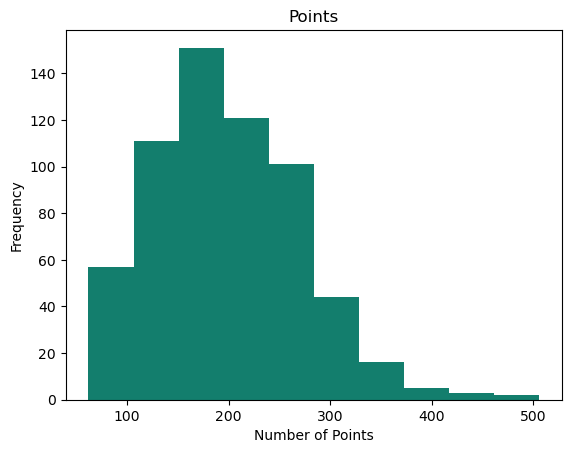

In [7]:
plt.hist(df['Points'], color = color1)
plt.xlabel('Number of Points')
plt.ylabel('Frequency')
plt.title('Points')

Text(0.5, 1.0, 'Words')

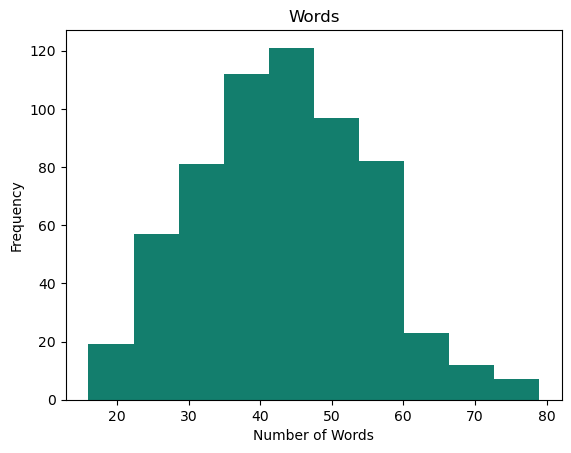

In [8]:
plt.hist(df['Words'], color = color1)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Words')

Text(0.5, 1.0, 'Pangrams')

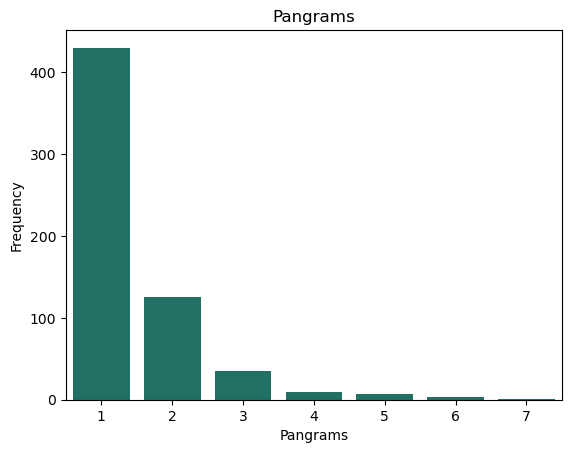

In [9]:
sns.countplot(x = df['Pangrams'], color = color1)
plt.xlabel('Pangrams')
plt.ylabel('Frequency')
plt.title('Pangrams')

Text(0.5, 1.0, 'Vowels')

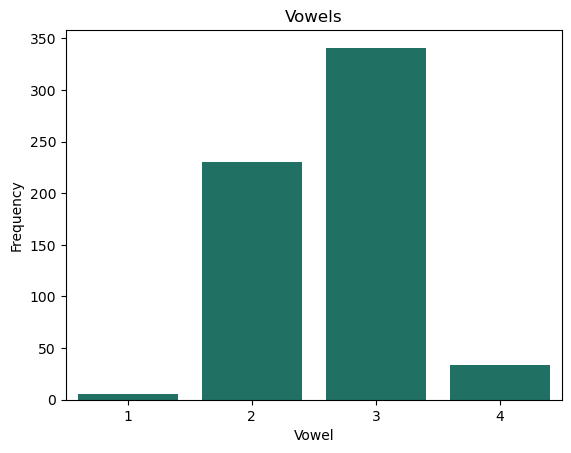

In [10]:
sns.countplot(x = df['Number of Vowels'], color = color1)
plt.xlabel('Vowel')
plt.ylabel('Frequency')
plt.title('Vowels')

Text(0.5, 1.0, 'Letter Frequencies of Other Six Letters')

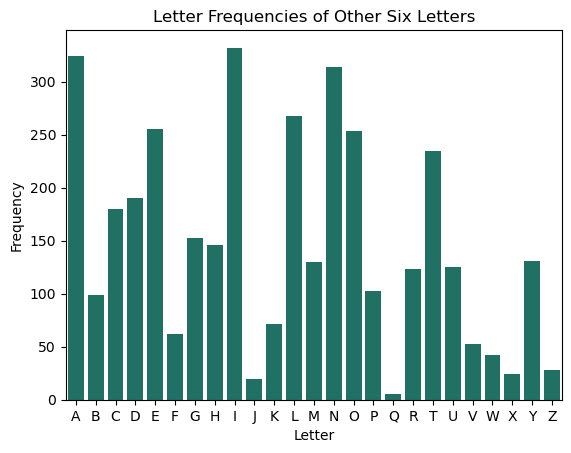

In [11]:
letters = df[['Letter 1', 'Letter 2', 'Letter 3', 'Letter 4', 'Letter 5', 'Letter 6']].values.flatten()
sns.countplot(x = sorted(letters), color = color1)
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Letter Frequencies of Other Six Letters')

Text(0.5, 1.0, 'Letter Frequencies of Center Letter')

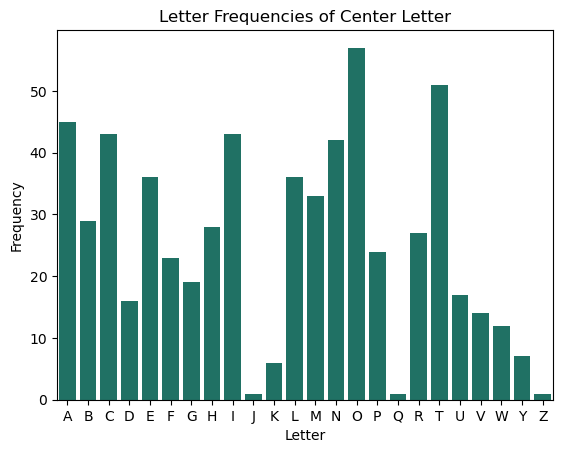

In [12]:
letters = df['Center Letter'].values.flatten()
sns.countplot(x = sorted(letters), color = color1)
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Letter Frequencies of Center Letter')

Text(0.5, 1.0, 'Bingo')

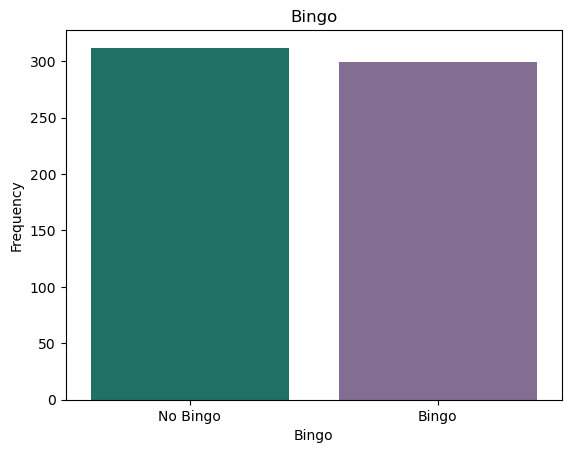

In [13]:
ax = sns.countplot(x = df['Bingo'], palette = [color1, color2])
ax.set_xticklabels(['No Bingo', 'Bingo'])
plt.xlabel('Bingo')
plt.ylabel('Frequency')
plt.title('Bingo')

Text(0.5, 1.0, 'Bingo and Other Six Letters')

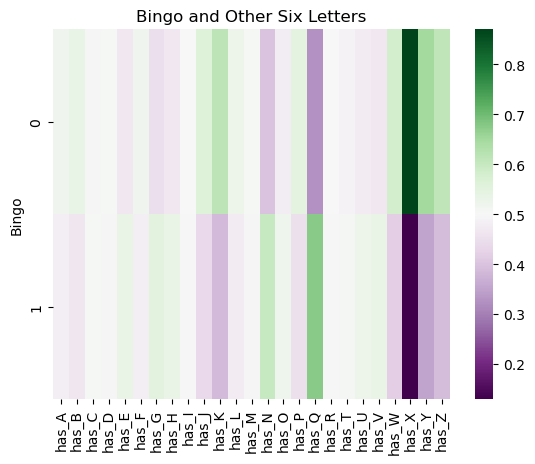

In [14]:
table = data.groupby('Bingo')[other_letter_labels].mean()
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Other Six Letters')

Text(0.5, 1.0, 'Bingo and Center Letter')

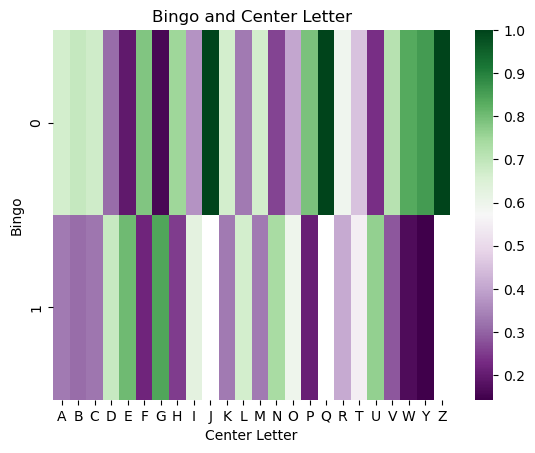

In [15]:
table = pd.pivot_table(df[['Bingo', 'Center Letter']], index = ['Bingo'], columns = ['Center Letter'], values = ['Bingo'], aggfunc = np.size)
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Center Letter')

Text(0.5, 1.0, 'Bingo and Number of Vowels')

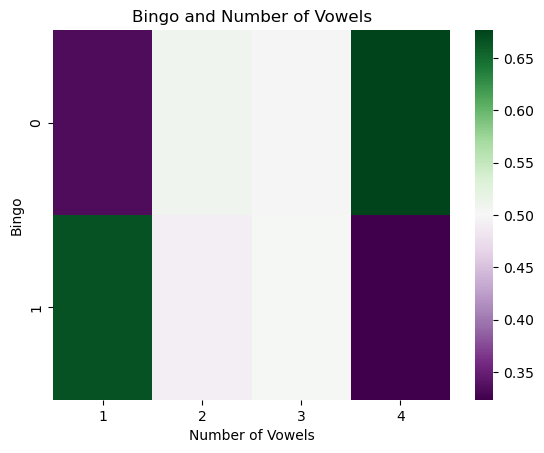

In [16]:
table = pd.pivot_table(df[['Bingo', 'Number of Vowels']], index = ['Bingo'], columns = ['Number of Vowels'], values = ['Bingo'], aggfunc = np.size)
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Number of Vowels')

Text(0.5, 1.0, 'Bingo and Number of Pangrams')

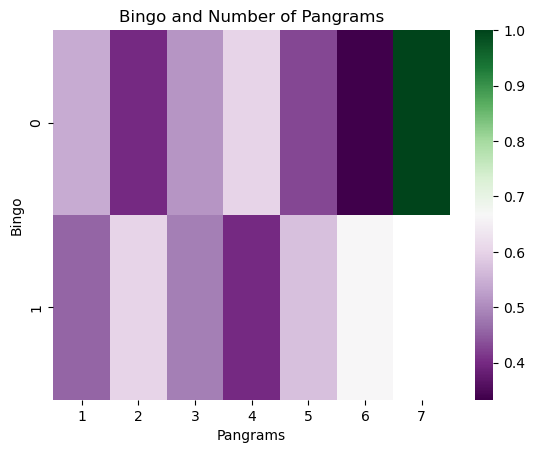

In [17]:
table = pd.pivot_table(df[['Bingo', 'Pangrams']], index = ['Bingo'], columns = ['Pangrams'], values = ['Bingo'], aggfunc = np.size)
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Number of Pangrams')

[Text(0, 0, 'No Bingo'), Text(1, 0, 'Bingo')]

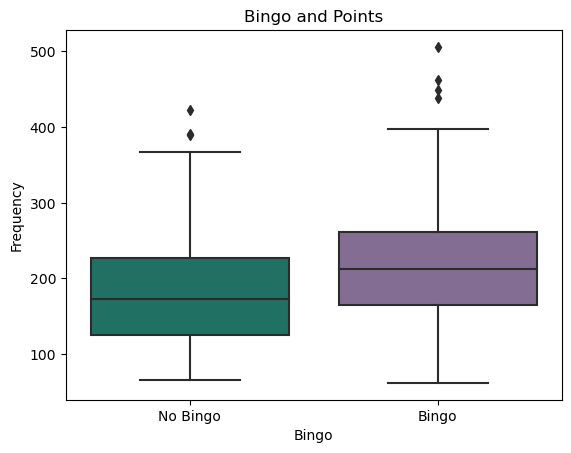

In [18]:
ax = sns.boxplot(y = df['Points'], x = df['Bingo'], palette = [color1, color2])
plt.xlabel('Bingo')
plt.ylabel('Frequency')
plt.title('Bingo and Points')
ax.set_xticklabels(['No Bingo', 'Bingo'])

[Text(0, 0, 'No Bingo'), Text(1, 0, 'Bingo')]

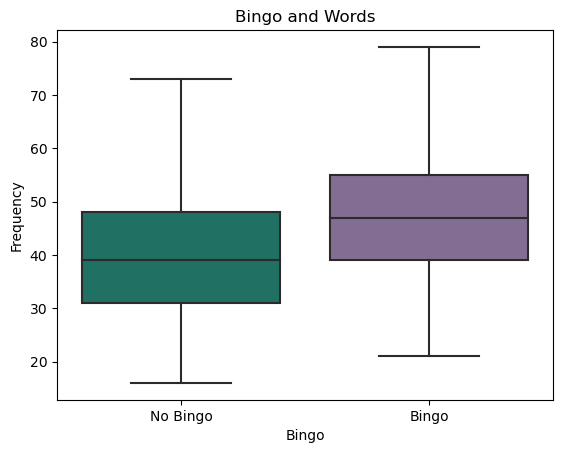

In [19]:
ax = sns.boxplot(y = df['Words'], x = df['Bingo'], palette = [color1, color2])
plt.xlabel('Bingo')
plt.ylabel('Frequency')
plt.title('Bingo and Words')
ax.set_xticklabels(['No Bingo', 'Bingo'])

In [20]:
num_tests = 3 + len(other_letter_labels) + len(center_letter_encoded.columns)
t, p = stats.ttest_ind(data[data['Bingo'] == 0]['Points'], data[data['Bingo'] == 1]['Points'])
print(f"Points\t\t p-value: {p:<30}\t t-stat: {t:<20}\t significant: {p<(0.05/num_tests)}")
t, p = stats.ttest_ind(data[data['Bingo'] == 0]['Words'], data[data['Bingo'] == 1]['Words'])
print(f"Words\t\t p-value: {p:<30}\t t-stat: {t:<20}\t significant: {p<(0.05/num_tests)}")
for l in center_letter_encoded.columns:
    combination = pd.crosstab(data['Bingo'], data[l])
    chi, p, x, x = stats.chi2_contingency(combination)
    print(f"{l:<10}\t p-value: {p:<30}\t chi: {chi:<20}\t significant: {p<(0.05/num_tests)}")

Points		 p-value: 3.6841023114645066e-09        	 t-stat: -5.985527713098524  	 significant: True
Words		 p-value: 4.716572829529018e-14         	 t-stat: -7.722233035341004  	 significant: True
center_A  	 p-value: 0.0433275885132668            	 chi: 4.082574750487927   	 significant: False
center_B  	 p-value: 0.07415406016103455           	 chi: 3.1885874878282507  	 significant: False
center_C  	 p-value: 0.03844455833988283           	 chi: 4.2852442559172035  	 significant: False
center_D  	 p-value: 0.17597748620131495           	 chi: 1.831271075006089   	 significant: False
center_E  	 p-value: 0.00018376866583605045        	 chi: 13.990172298361696  	 significant: True
center_F  	 p-value: 0.014397927406456117          	 chi: 5.98868553998474    	 significant: False
center_G  	 p-value: 0.003831738877140536          	 chi: 8.361880236035521   	 significant: False
center_H  	 p-value: 0.016378966795998238          	 chi: 5.76172683747412    	 significant: False
center_I  	 p-

In [21]:
for l in other_letter_labels:
    combination = pd.crosstab(data['Bingo'], data[l])
    chi, p, x, x = stats.chi2_contingency(combination)
    print(f"{l:<10}\t p-value: {p:<30}\t chi: {chi:<20}\t significant: {p<(0.05/num_tests)}")

has_A     	 p-value: 0.3148185700258302            	 chi: 1.0103518139961933  	 significant: False
has_B     	 p-value: 0.4105163058047834            	 chi: 0.6773049403800784  	 significant: False
has_C     	 p-value: 0.9500911713998116            	 chi: 0.003917794401017365	 significant: False
has_D     	 p-value: 0.9578792457087715            	 chi: 0.002789432736286739	 significant: False
has_E     	 p-value: 0.14051063543934178           	 chi: 2.1723580285606188  	 significant: False
has_F     	 p-value: 0.7977614079553365            	 chi: 0.06566166948677277 	 significant: False
has_G     	 p-value: 0.13388731777176813           	 chi: 2.24684285180839    	 significant: False
has_H     	 p-value: 0.33727495407895713           	 chi: 0.9207620815355092  	 significant: False
has_I     	 p-value: 0.9985891226208374            	 chi: 3.126791124212767e-06	 significant: False
has_J     	 p-value: 0.7301008310357835            	 chi: 0.1190190707208943  	 significant: False
has_K    

### Data Modeling and Prediction
- create and run models
- train-test split

In [52]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = data.drop(["Bingo", "Date"], axis=1)
y = data["Bingo"]

# train test split with all features.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        
    random_state=42,
    stratify=y  # do this for stratified testing, so we have an equal number of T/F bingo in train and test.
)


# another train test split with features shown to be significant from the statistical test
X_sig = data[["Points", "Words", "Pangrams", "Number of Vowels", "center_E", "has_X", "has_Y"]]

X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(
    X_sig, y,
    test_size=0.2,        
    random_state=42,
    stratify=y  # do this for stratified testing, so we have an equal number of T/F bingo in train and test.
)


Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression_sig = LogisticRegression()

logistic_regression.fit(X_train, y_train)
logistic_regression_sig.fit(X_train_sig, y_train_sig)


LogisticRegression()

Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest_sig = RandomForestClassifier()

random_forest.fit(X_train, y_train)
random_forest_sig.fit(X_train_sig, y_train_sig)

RandomForestClassifier()

Gradient Boost

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost = GradientBoostingClassifier()
gradient_boost_sig = GradientBoostingClassifier()

gradient_boost.fit(X_train, y_train)
gradient_boost_sig.fit(X_train_sig, y_train_sig)

GradientBoostingClassifier()

Support Vector Machine

In [26]:
from sklearn.svm import SVC 

svc = SVC()
svc_sig = SVC()

svc.fit(X_train, y_train)
svc_sig.fit(X_train_sig, y_train_sig)

SVC()

In [27]:
# since the classes are pretty well balanced, we will use accuracy as our metric.
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(logistic_regression, X_test, y_test, "Logistic Regression (All Features)")
evaluate_model(logistic_regression_sig, X_test_sig, y_test_sig, "Logistic Regression (Significant Only)")

evaluate_model(random_forest, X_test, y_test, "Random Forest (All Features)")
evaluate_model(random_forest_sig, X_test_sig, y_test_sig, "Random Forest (Significant Only)")

evaluate_model(gradient_boost, X_test, y_test, "Gradient Boosting (All Features)")
evaluate_model(gradient_boost_sig, X_test_sig, y_test_sig, "Gradient Boosting (Significant Only)")

evaluate_model(svc, X_test, y_test, "Support Vector Classifier (All Features)")
evaluate_model(svc_sig, X_test_sig, y_test_sig, "Support Vector Classifier (Significant Only)")


Logistic Regression (All Features)
Accuracy: 0.7235772357723578
F1 Score: 0.711864406779661
Confusion Matrix:
 [[47 16]
 [18 42]]

Logistic Regression (Significant Only)
Accuracy: 0.6910569105691057
F1 Score: 0.7076923076923077
Confusion Matrix:
 [[39 24]
 [14 46]]

Random Forest (All Features)
Accuracy: 0.6991869918699187
F1 Score: 0.6782608695652174
Confusion Matrix:
 [[47 16]
 [21 39]]

Random Forest (Significant Only)
Accuracy: 0.6178861788617886
F1 Score: 0.624
Confusion Matrix:
 [[37 26]
 [21 39]]

Gradient Boosting (All Features)
Accuracy: 0.6991869918699187
F1 Score: 0.6837606837606838
Confusion Matrix:
 [[46 17]
 [20 40]]

Gradient Boosting (Significant Only)
Accuracy: 0.6016260162601627
F1 Score: 0.6201550387596899
Confusion Matrix:
 [[34 29]
 [20 40]]

Support Vector Classifier (All Features)
Accuracy: 0.7073170731707317
F1 Score: 0.6785714285714285
Confusion Matrix:
 [[49 14]
 [22 38]]

Support Vector Classifier (Significant Only)
Accuracy: 0.6341463414634146
F1 Score: 0.6

It seems that logistic regresion gives the best accuracy without any tuning. Let's do some hyperparameter tuning to increase accuracy more.

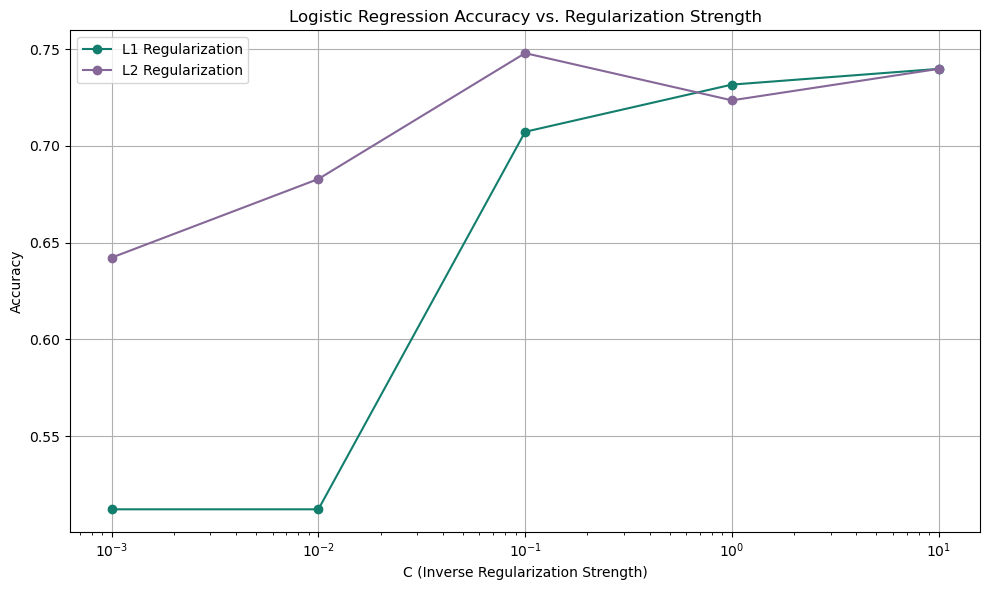

In [49]:
# different regularization terms
C_vals = [0.001, 0.01, 0.1, 1, 10]

l1_accuracies = []
l2_accuracies = []

for C_val in C_vals:
    l1_reg = LogisticRegression(penalty="l1", solver="liblinear", C=C_val, max_iter=10000)
    l1_reg.fit(X_train, y_train)
    l1_pred = l1_reg.predict(X_test)
    l1_accuracies.append(accuracy_score(y_test, l1_pred))

    l2_reg =  LogisticRegression(penalty="l2", solver="lbfgs", C=C_val, max_iter=10000)
    l2_reg.fit(X_train, y_train)
    l2_pred = l2_reg.predict(X_test)
    l2_accuracies.append(accuracy_score(y_test, l2_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_vals, l1_accuracies, marker='o', label='L1 Regularization', color=color1)
plt.plot(C_vals, l2_accuracies, marker='o', label='L2 Regularization', color=color2)
plt.xscale('log')
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. Regularization Strength")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best Parameters with explanation:
- L2 regularization shrinks all features but won't set small features to zero: each feature plays a part in the final model.
- Limited Memory BFGS (lbfgs) is the optimization algorithm we use to minimize the cost function. Complicated but it works with L2 Regularization.
- Lower C-values penalize large weights more than high C-values. A c-value of 0.1 is right in the middle of penalizing too much and too little - i guess it's just right or something


Random Forest (All Features)
Accuracy: 0.7479674796747967
F1 Score: 0.7304347826086957
Confusion Matrix:
 [[50 13]
 [18 42]]


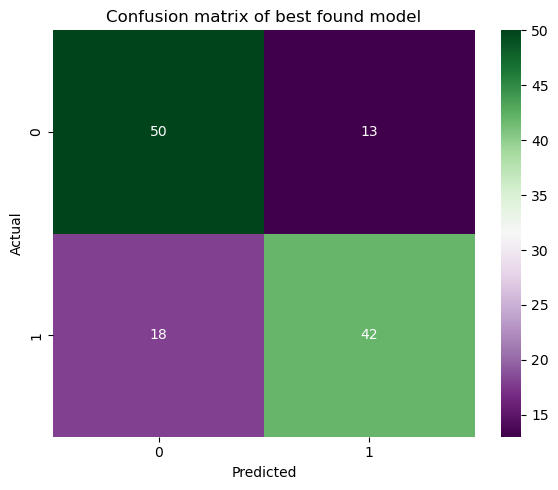

In [50]:
best_model = LogisticRegression(penalty="l2", solver="lbfgs", C=0.1)
best_model.fit(X_train, y_train)

evaluate_model(best_model, X_test, y_test, "Random Forest (All Features)")
y_pred = best_model.predict(X_test)

# plot the confusion matrix.
cm = confusion_matrix(y_test, y_pred)
    
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap=div_color)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion matrix of best found model")
plt.tight_layout()
plt.show()

In [ ]:
# Let's see the weights
coeffs = best_model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coeffs
}).sort_values(by='Weight', key=abs, ascending=False)

coef_df.head(10)

,Feature,Weight
1,Words,0.685193
8,center_E,0.585734
50,has_X,-0.564586
41,has_N,0.540871
17,center_N,0.447361
6,center_C,-0.431163
19,center_P,-0.427247
12,center_I,0.394260
16,center_M,-0.388631
4,center_A,-0.361285


From above, we see that the amount of words is the most important feature for determinig if there will be a bingo. More words = more likely. Center E, center N or having an N, and center I are all positively correlated with having a bingo. Having an X, as well as center P, C, M, and A, are all negatively correlated with bingo.

### Results Analysis
- write stuff
- make presentation